### Experiment 1 (adjust hierarchy thresholds)

In [1]:
import pandas as pd
import numpy as np
%load_ext autoreload
%autoreload 2

from simulation import run_simulation, initialize_simulation, MetricsHandler, InteractionHandler

def run_experiment1(num_iterations, hierarchy_thresholds):
    results = {}

    for ht in hierarchy_thresholds:
        average_information_dissemination = pd.DataFrame()
        average_spatial_usage = pd.DataFrame()
        average_spatial_usage_by_type = pd.DataFrame()
        all_centrality_metrics = []

        for i in range(num_iterations):
            emps, spaces, team_graph, friendship_graph = initialize_simulation(num_employees, num_teams, min_team_size,
                                                                            num_friendships, num_spaces, space_types, space_capacities, hierarchy_levels, hierarchy_adjustment_factor)

            metrics_handler = run_simulation(emps, spaces, 10, initial_info_holder=6, team_graph=team_graph, friendship_graph=friendship_graph, hierarchy_threshold=ht)
            metrics_handler.calculate_centrality_metrics()
            metrics_handler.calculate_spatial_usage()

            average_information_dissemination = average_information_dissemination.add(metrics_handler.information_dissemination, fill_value=0)
            average_spatial_usage = average_spatial_usage.add(metrics_handler.spatial_usage, fill_value=0)
            all_centrality_metrics.append(metrics_handler.centrality_metrics)
            average_spatial_usage_by_type = average_spatial_usage_by_type.add(metrics_handler.spatial_usage_by_type, fill_value=0)

        average_information_dissemination = average_information_dissemination / num_iterations
        average_spatial_usage = average_spatial_usage / num_iterations
        average_spatial_usage_by_type = average_spatial_usage_by_type / num_iterations
        # Calculate average centrality metrics per hierarchy level
        average_centrality_metrics = pd.concat(all_centrality_metrics).groupby('hierarchy_level').mean().reset_index()

        results[ht] = (average_information_dissemination, average_spatial_usage, average_centrality_metrics, average_spatial_usage_by_type)

    return results


num_employees = 100
num_teams = 10
min_team_size = 8
num_friendships = 5
num_spaces = 18
space_types = ["Workstation"] * 10 + ["Meeting Room"] * 3 + ["Break Area"] * 3 + ["Quiet Area"] * 2
space_capacities = [10] * 10 + [15] * 3 + [20] * 3 + [10] * 2
hierarchy_levels = 5
hierarchy_adjustment_factor = 0.5

num_iterations = 10
hierarchy_thresholds = [1, 2, 3]

experiment_results = run_experiment1(num_iterations, hierarchy_thresholds)


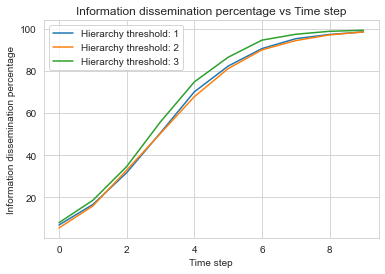

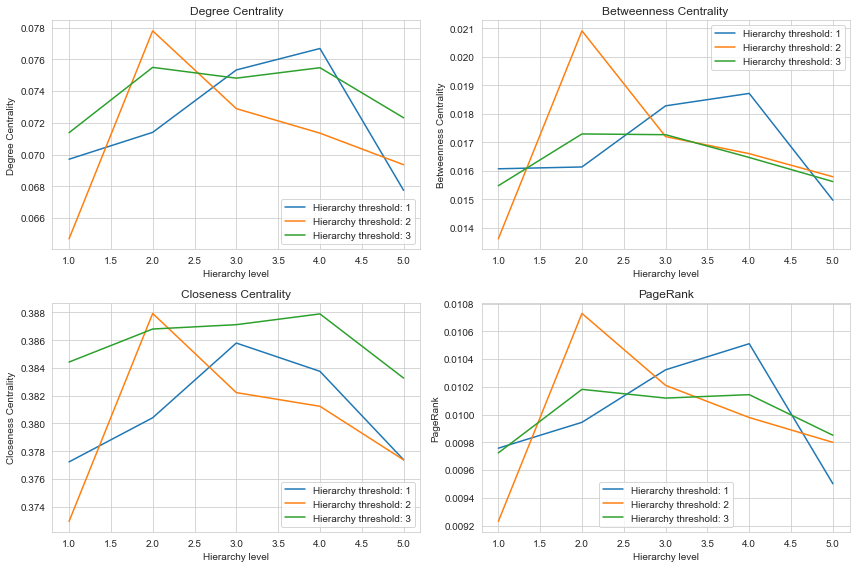

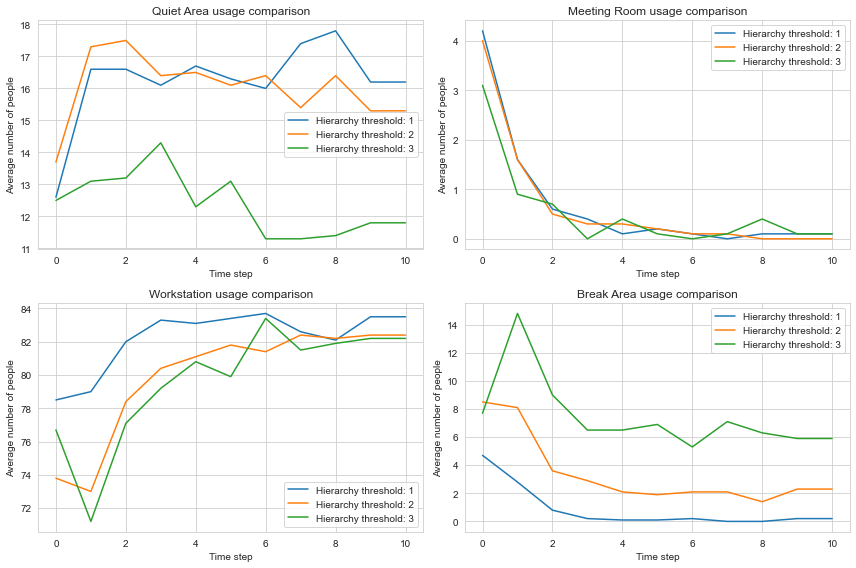

In [2]:
## plot results
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

FOLDER = 'plots/'

## set white background
sns.set_style("whitegrid")

# Plot information dissemination percentage vs time step
for ht, (info_dissemination, _, _, _) in experiment_results.items():
    plt.plot(info_dissemination['time_step'], info_dissemination['informed_percentage'], label=f'Hierarchy threshold: {ht}')
plt.xlabel('Time step')
plt.ylabel('Information dissemination percentage')
plt.legend()
plt.title('Information dissemination percentage vs Time step')
plt.savefig(FOLDER + 'info_dissemination.png')
plt.show()

## plotting centrality metrics
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
centralities = ['degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'pagerank']
titles = ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'PageRank']

for i, (ax, centrality, title) in enumerate(zip(axs.flat, centralities, titles)):
    for ht, (_, _, centrality_metrics, _) in experiment_results.items():
        ax.plot(centrality_metrics['hierarchy_level'], centrality_metrics[centrality], label=f'Hierarchy threshold: {ht}')
    ax.set_xlabel('Hierarchy level')
    ax.set_ylabel(title)
    ax.legend()
    ax.set_title(title)

plt.tight_layout()
plt.savefig(FOLDER + 'centrality_metrics.png')
plt.show()

## spatial usage
space_types = list(set(space_types))
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
for i, space_type in enumerate(space_types):
    for ht, (_, _, _, spatial_usage_by_type) in experiment_results.items():
        axes[i].plot(spatial_usage_by_type.index, spatial_usage_by_type[space_type], label=f'Hierarchy threshold: {ht}')
    axes[i].set_xlabel('Time step')
    axes[i].set_ylabel('Average number of people')
    axes[i].legend()
    axes[i].set_title(f'{space_type} usage comparison')

plt.tight_layout()
plt.savefig(FOLDER + 'space_type_usage_comparison.png')
plt.show()


### Experiment 2 (adjust hierarchy levels)

In [3]:
def run_experiment2(num_iterations, hierarchy_levels):
    results = {}

    for hl in hierarchy_levels:
        average_information_dissemination = pd.DataFrame()
        average_spatial_usage = pd.DataFrame()
        average_spatial_usage_by_type = pd.DataFrame()
        all_centrality_metrics = []

        for i in range(num_iterations):
            emps, spaces, team_graph, friendship_graph = initialize_simulation(num_employees, num_teams, min_team_size,
                                                                            num_friendships, num_spaces, space_types, space_capacities, hl, hierarchy_adjustment_factor)

            metrics_handler = run_simulation(emps, spaces, 10, initial_info_holder=6, team_graph=team_graph, friendship_graph=friendship_graph, hierarchy_threshold=hierarchy_threshold)
            metrics_handler.calculate_centrality_metrics()
            metrics_handler.calculate_spatial_usage()

            average_information_dissemination = average_information_dissemination.add(metrics_handler.information_dissemination, fill_value=0)
            average_spatial_usage = average_spatial_usage.add(metrics_handler.spatial_usage, fill_value=0)
            centrality_metrics = metrics_handler.centrality_metrics.copy()
            centrality_metrics['experiment_hl'] = hl
            all_centrality_metrics.append(centrality_metrics)
            average_spatial_usage_by_type = average_spatial_usage_by_type.add(metrics_handler.spatial_usage_by_type, fill_value=0)

        average_information_dissemination = average_information_dissemination / num_iterations
        average_spatial_usage = average_spatial_usage / num_iterations
        average_spatial_usage_by_type = average_spatial_usage_by_type / num_iterations
        # Calculate average centrality metrics per hierarchy level
        average_centrality_metrics = pd.concat(all_centrality_metrics).groupby(['hierarchy_level', 'experiment_hl']).mean().reset_index()
        # Make sure we have the same number of rows for each hierarchy level
        for missing_hl in set(range(1, max(hierarchy_levels) + 1)).difference(set(average_centrality_metrics['hierarchy_level'])):
            missing_row = pd.DataFrame({'hierarchy_level': [missing_hl],
                                        'experiment_hl': [hl],
                                        'degree_centrality': [0],
                                        'betweenness_centrality': [0],
                                        'closeness_centrality': [0],
                                        'pagerank': [0]})
            average_centrality_metrics = average_centrality_metrics.append(missing_row, ignore_index=True)

        results[hl] = (average_information_dissemination, average_spatial_usage, average_centrality_metrics, average_spatial_usage_by_type)

    return results



num_employees = 100
num_teams = 10
min_team_size = 8
num_friendships = 5
num_spaces = 18
space_types = ["Workstation"] * 10 + ["Meeting Room"] * 3 + ["Break Area"] * 3 + ["Quiet Area"] * 2
space_capacities = [10] * 10 + [15] * 3 + [20] * 3 + [10] * 2
hierarchy_threshold = 3
hierarchy_adjustment_factor = 0.5

num_iterations = 10
hierarchy_levels = [1, 2, 3, 4, 5]

experiment_results = run_experiment2(num_iterations, hierarchy_levels)


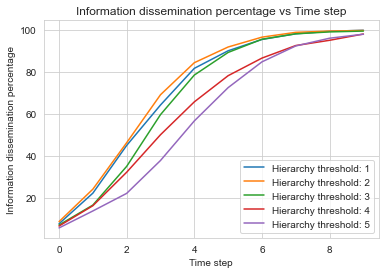

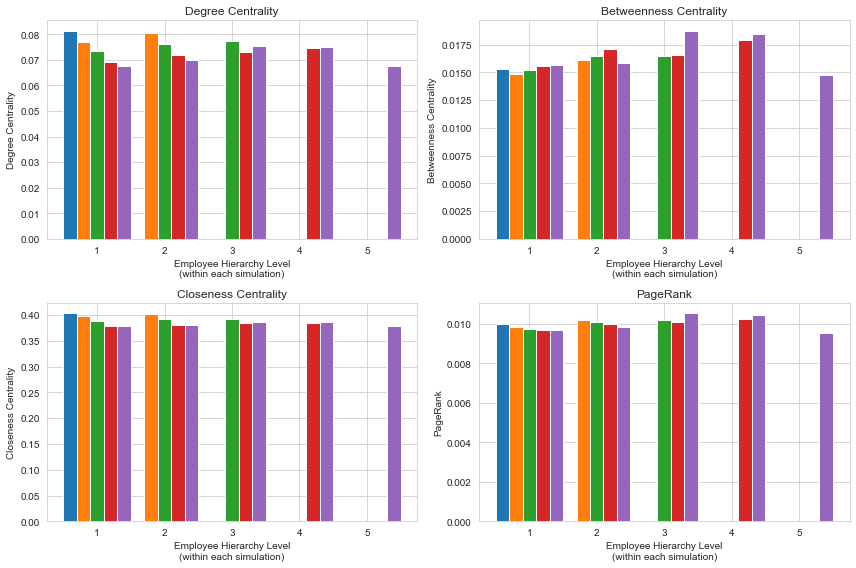

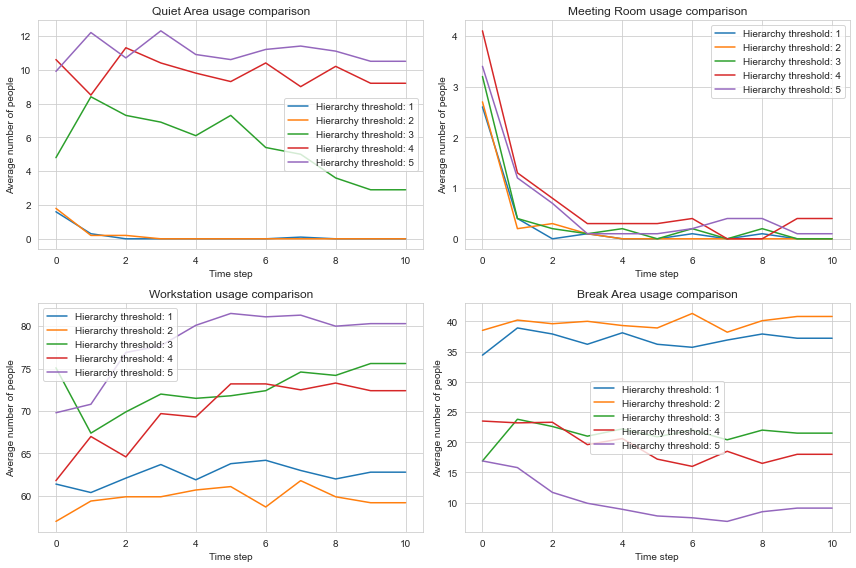

In [4]:
## plot results

FOLDER = 'plots/'

## set white background
sns.set_style("whitegrid")

# Plot information dissemination percentage vs time step
for hl, (info_dissemination, _, _, _) in experiment_results.items():
    plt.plot(info_dissemination['time_step'], info_dissemination['informed_percentage'], label=f'Hierarchy threshold: {hl}')
plt.xlabel('Time step')
plt.ylabel('Information dissemination percentage')
plt.legend()
plt.title('Information dissemination percentage vs Time step')
plt.savefig(FOLDER + 'info_dissemination2.png')
plt.show()

## plotting centrality metrics
num_hierarchy_levels = len(set(hierarchy_levels))
bar_width = 0.2
bar_positions = np.arange(num_hierarchy_levels)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
centralities = ['degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'pagerank']
titles = ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'PageRank']

for i, (ax, centrality, title) in enumerate(zip(axs.flat, centralities, titles)):
    for j, (hl, (_, _, centrality_metrics, _)) in enumerate(experiment_results.items()):
        ax.bar(bar_positions + j * bar_width, centrality_metrics[centrality], width=bar_width, label=f'Hierarchy threshold: {hl}')
    
    ax.set_xticks(bar_positions + bar_width * (len(hierarchy_levels) - 1) / 2)
    ax.set_xticklabels(range(1, num_hierarchy_levels + 1))
    ax.set_xlabel('Employee Hierarchy Level\n(within each simulation)')
    ax.set_ylabel(title)
    # ax.legend()
    ax.set_title(title)

plt.tight_layout()
plt.savefig(FOLDER + 'centrality_metrics_exp2.png')
plt.show()

## spatial usage
space_types = list(set(space_types))
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
for i, space_type in enumerate(space_types):
    for hl, (_, _, _, spatial_usage_by_type) in experiment_results.items():
        axes[i].plot(spatial_usage_by_type.index, spatial_usage_by_type[space_type], label=f'Hierarchy threshold: {hl}')
    axes[i].set_xlabel('Time step')
    axes[i].set_ylabel('Average number of people')
    axes[i].legend()
    axes[i].set_title(f'{space_type} usage comparison')

plt.tight_layout()
plt.savefig(FOLDER + 'space_type_usage_comparison2.png')
plt.show()


### Experiment 3 (hierarchy adjustment factor)

In [5]:
def run_experiment3(num_iterations, adjustment_factors):
    results = {}

    for af in adjustment_factors:
        average_information_dissemination = pd.DataFrame()
        average_spatial_usage = pd.DataFrame()
        average_spatial_usage_by_type = pd.DataFrame()
        all_centrality_metrics = []

        for i in range(num_iterations):
            emps, spaces, team_graph, friendship_graph = initialize_simulation(num_employees, num_teams, min_team_size,
                                                                            num_friendships, num_spaces, space_types, space_capacities, hierarchy_levels, af)

            metrics_handler = run_simulation(emps, spaces, 10, initial_info_holder=6, team_graph=team_graph, friendship_graph=friendship_graph, hierarchy_threshold=hierarchy_threshold)
            metrics_handler.calculate_centrality_metrics()
            metrics_handler.calculate_spatial_usage()

            average_information_dissemination = average_information_dissemination.add(metrics_handler.information_dissemination, fill_value=0)
            average_spatial_usage = average_spatial_usage.add(metrics_handler.spatial_usage, fill_value=0)
            all_centrality_metrics.append(metrics_handler.centrality_metrics)
            average_spatial_usage_by_type = average_spatial_usage_by_type.add(metrics_handler.spatial_usage_by_type, fill_value=0)

        average_information_dissemination = average_information_dissemination / num_iterations
        average_spatial_usage = average_spatial_usage / num_iterations
        average_spatial_usage_by_type = average_spatial_usage_by_type / num_iterations
        # Calculate average centrality metrics per hierarchy level
        average_centrality_metrics = pd.concat(all_centrality_metrics).groupby('hierarchy_level').mean().reset_index()

        results[af] = (average_information_dissemination, average_spatial_usage, average_centrality_metrics, average_spatial_usage_by_type)

    return results


num_employees = 100
num_teams = 10
min_team_size = 8
num_friendships = 5
num_spaces = 18
space_types = ["Workstation"] * 10 + ["Meeting Room"] * 3 + ["Break Area"] * 3 + ["Quiet Area"] * 2
space_capacities = [10] * 10 + [15] * 3 + [20] * 3 + [10] * 2
hierarchy_levels = 5
hierarchy_threshold = 3

num_iterations = 10
adjustment_factors = [0.2, 0.5, 0.8]

experiment_results = run_experiment3(num_iterations, adjustment_factors)


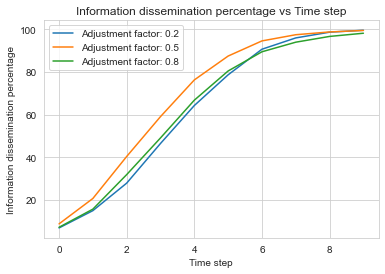

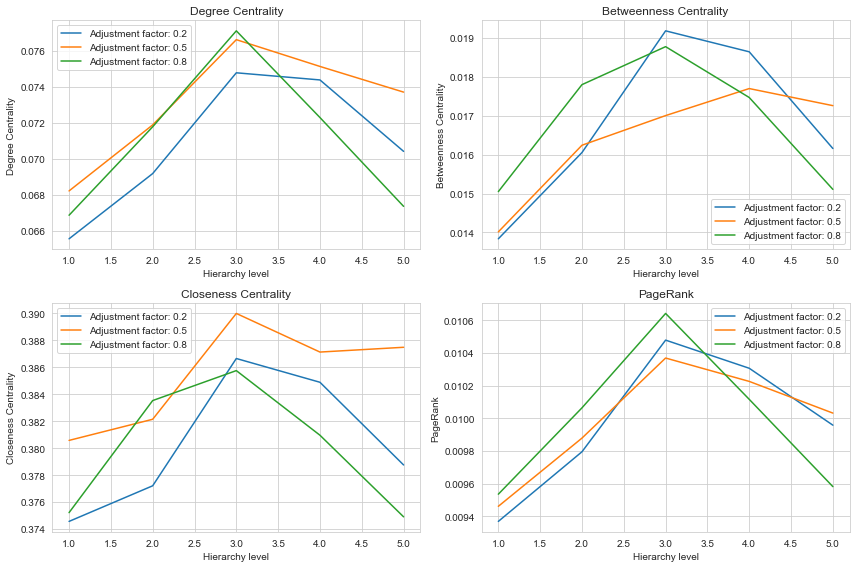

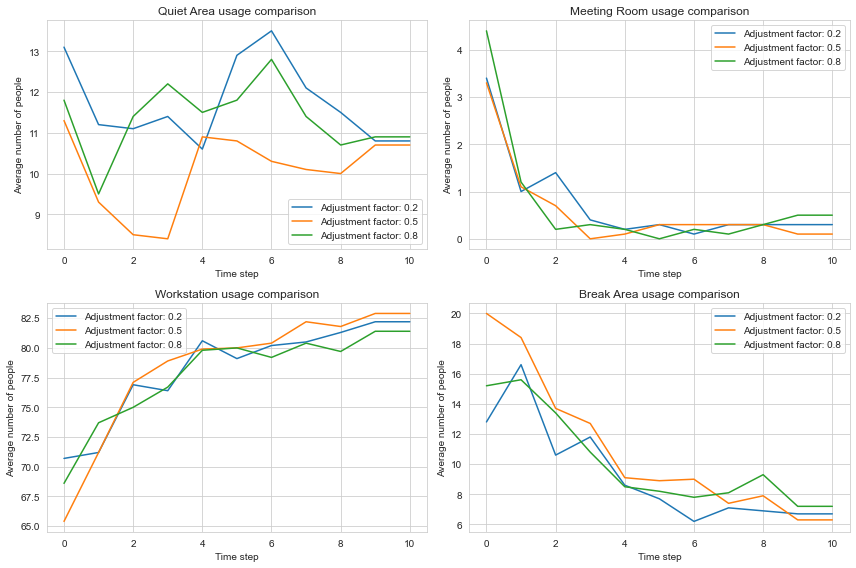

In [6]:
FOLDER = 'plots/'
sns.set_style("whitegrid")

# Plot information dissemination percentage vs time step
for af, (info_dissemination, _, _, _) in experiment_results.items():
    plt.plot(info_dissemination['time_step'], info_dissemination['informed_percentage'], label=f'Adjustment factor: {af}')
plt.xlabel('Time step')
plt.ylabel('Information dissemination percentage')
plt.legend()
plt.title('Information dissemination percentage vs Time step')
plt.savefig(FOLDER + 'info_dissemination_exp3.png')
plt.show()

# Plot centrality metrics
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
centralities = ['degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'pagerank']
titles = ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'PageRank']

for i, (ax, centrality, title) in enumerate(zip(axs.flat, centralities, titles)):
    for af, (_, _, centrality_metrics, _) in experiment_results.items():
        ax.plot(centrality_metrics['hierarchy_level'], centrality_metrics[centrality], label=f'Adjustment factor: {af}')
    ax.set_xlabel('Hierarchy level')
    ax.set_ylabel(title)
    ax.legend()
    ax.set_title(title)

plt.tight_layout()
plt.savefig(FOLDER + 'centrality_metrics_exp3.png')
plt.show()

# Plot spatial usage
space_types = list(set(space_types))
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
for i, space_type in enumerate(space_types):
    for af, (_, _, _, spatial_usage_by_type) in experiment_results.items():
        axes[i].plot(spatial_usage_by_type.index, spatial_usage_by_type[space_type], label=f'Adjustment factor: {af}')
    axes[i].set_xlabel('Time step')
    axes[i].set_ylabel('Average number of people')
    axes[i].legend()
    axes[i].set_title(f'{space_type} usage comparison')

plt.tight_layout()
plt.savefig(FOLDER + 'space_type_usage_comparison_exp3.png')
plt.show()
